# Filtrado adaptativo por bloques

Procesamiento Adaptativo de Señales Aleatorias

© Marc S. Ressl

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

En este ejemplo comparamos el algoritmo LMS con el algoritmo RLS.

Aplicaremos ambos algoritmos a un problema de ecualización de un canal de comunicaciones.

## Modelo del canal

* El canal se alimenta con una secuencia de Bernoulli $x_n$ de valor ±1.
* A la salida del canal hay ruido $v(n)$.
* El canal tiene respuesta al impulso:

$$h(n) = \begin{cases}
\dfrac{1}{2} (1 + \cos(\dfrac{2 π}{W} (n - 2)), & n = 1, 2, 3\\
0, &\mathrm{sino}\end{cases}$$

* El parámetro $W$ permite controlar la distorsión del canal, y por tanto el spread de autovalores.
* Conforme aumenta $W$, aumenta la distorsión del canal y el spread de autovalores.

In [2]:
# Parámetros del canal
M = 11
sigma2v = 0.001

def calc_h(W):
    h = 0.5 * (1.0 + np.cos(2 * np.pi / W * (np.arange(0, 5) - 2)))
    h[0] = h[4] = 0
    
    return h

def get_model_input(N):
    d = (np.random.rand(N) > 0.5) * 2.0 - 1.0
    return d

def get_model_output(d, W):
    h = calc_h(W)
    
    u = signal.lfilter(h, [1], d)
    v = np.random.normal(0, np.sqrt(sigma2v), size=len(u))
    
    return u + v

Un ejemplo para $W = 2.7$:

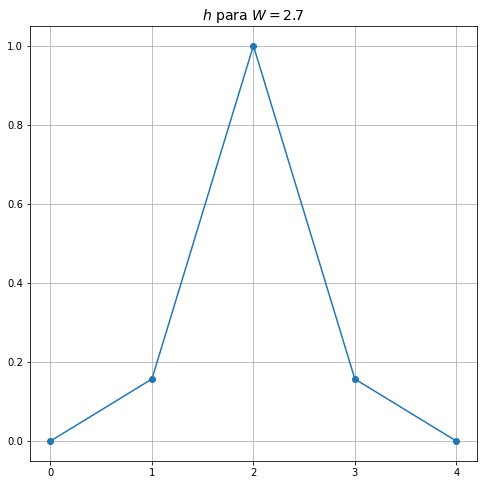

In [3]:
h = calc_h(2.7)

plt.figure(figsize=(8, 8))
plt.plot(h, marker='o')
plt.title('$h$ para $W = 2.7$', fontsize=14)
plt.xticks(np.arange(0, 5, 1))
plt.grid(True)
plt.show()

* El largo del filtro $h(n)$ es de 5 taps. Su retardo medio es de 2 taps.
* Realizaremos la inversión con un filtro de 11 taps. Al ser $h(n)$ simétrico, su inverso también será simétrico, y su retardo medio será de 5 taps.
* Añadimos al ecualizador un retardo de 7 taps, para compensar el retardo medio del filtro $h(n)$ (2 taps) y el retardo medio del ecualizador (5 taps).

In [4]:
eq_delay = 7

## Implementación LMS

Utilizaremos el valor $µ = 0.05$.

In [5]:
mu = 0.05

In [6]:
mu = 0.05
# Ecualizador LMS
def calc_lms_montecarlo(K, mu, N, w0, W):
    """
    Realiza una simulación de Monte-Carlo del algoritmo LMS
    aplicado a un problema de ecualización.
    
    K: número de simulaciones de Monte-Carlo
    mu: parámetro de paso
    N: número de iteraciones
    w0: valor inicial del filtro adaptativo
    W: parámetro del canal
    """

    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, M))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        # Modelo de señal
        d = get_model_input(N + M - 1)
        u = get_model_output(d, W)

        # Ecualización LMS
        w = np.zeros((N, M))
        J = np.zeros((N, 1))
        w[0] = w0
        
        for n in range(1, N):
            u_flipped = np.flipud(u[n:n + M])
            y = np.dot(w[n - 1].T, u_flipped)              # Ecuación de filtrado
            e = d[n + M - 1 - eq_delay] - y
            J[n - 1] = e * e
            w[n] = w[n - 1] + mu * u_flipped * e           # Ecuación LMS
            
        J[N - 1] = J[N - 2]
        
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)

## Implementación RLS

Para determinar el factor de olvido de RLS solemos basarnos en la constante de tiempo τ. En sistemas de tiempo discreto:

$$\tau = -\frac{1}{ln(\lambda)}$$

De modo que:

$$\lambda = e^{-1 / \tau}$$



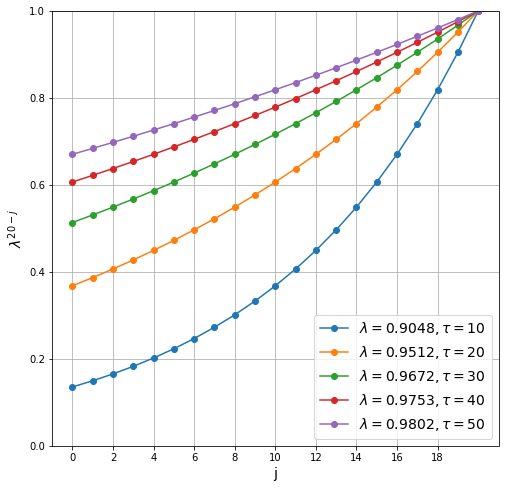

In [7]:
time_constants = np.linspace(10, 50, 5)
num_values = 20
x = np.arange(0, num_values + 1)

plt.figure(figsize=(8, 8))
for time_constant in time_constants:
    lamda = np.exp(- 1 / time_constant)
    y = np.power(lamda, num_values - x)
    plt.plot(x, y, marker='o', label='$λ=%.4f, τ=%.0d$' % (lamda, time_constant))
plt.ylim([0,1])
plt.xlabel('j', fontsize=14)
plt.ylabel('$λ^{%s - j}$' % num_values, fontsize=14)
plt.xticks(np.arange(0, num_values, 2))
plt.grid(True)
legend = plt.legend(loc='lower right', fontsize=14)
plt.show()

* En este ejemplo fijamos $λ = 1$, ya que el sistema es estacionario.
* Utilizamos un factor de regularización $δ$ pequeño, ya que el ruido es bajo.

In [8]:
lamda = 1.0
delta = 0.04

In [9]:
# Ecualizador RLS
def calc_rls_montecarlo(K, lamda, delta, N, w0, W):
    """
    Realiza una simulación de Monte-Carlo del algoritmo RLS
    aplicado a un problema de ecualización.
    
    K: número de simulaciones de Monte-Carlo
    lamda: factor de olvido de RLS
    delta: parámetro de regularización de RLS
    N: número de iteraciones
    w0: valor inicial del filtro adaptativo
    W: parámetro del canal
    """
    
    lamda1 = 1 / lamda

    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, M))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        # Modelo de señal
        d = get_model_input(N + M - 1)
        u = get_model_output(d, W)

        # Ecualización RLS
        w = np.zeros((N, M))
        J = np.zeros((N, 1))
        w[0] = w0
        P = np.eye(M) / delta

        for n in range(1, N):
            u_flipped = np.flipud(u[n:n + M]).reshape((M, 1))
            y = np.dot(w[n - 1].T, u_flipped)              # Ecuación de filtrado
            e = d[n + M - 1 - eq_delay] - y
            J[n - 1] = e * e
            lamda1Pu = lamda1 * np.dot(P, u_flipped)       # Ecuaciones RLS
            k = lamda1Pu / (1 + np.dot(u_flipped.T, lamda1Pu))
            w[n] = w[n - 1] + k.reshape(M) * np.conj(e);
            P = lamda1 * P - np.dot(k, lamda1Pu.T)
            
        J[N - 1] = J[N - 2]
        
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)

In [10]:
N = 500
w0 = np.zeros(M)
W = [2.7, 2.9, 3.1, 3.3]

## Convergencia de una realización

In [11]:
K = 1

In [12]:
w_lms, J_lms = calc_lms_montecarlo(K, mu, N, w0, W[0])

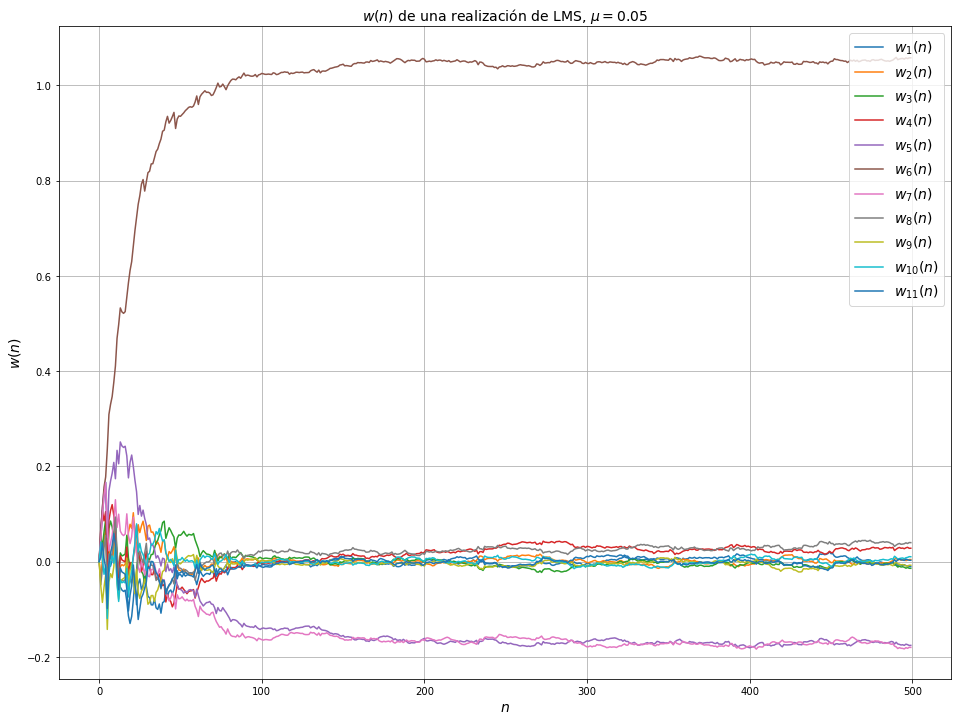

In [13]:
plt.figure(figsize=(16, 12))
for i in range(M):
    plt.plot(w_lms[:, i], label='$w_{%s}(n)$' % (i + 1))
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$w(n)$', fontsize=14)
plt.grid(True)
plt.title('$w(n)$ de una realización de LMS, $µ=%s$' % mu, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [14]:
w_rls, J_rls = calc_rls_montecarlo(K, lamda, delta, N, w0, W[0])

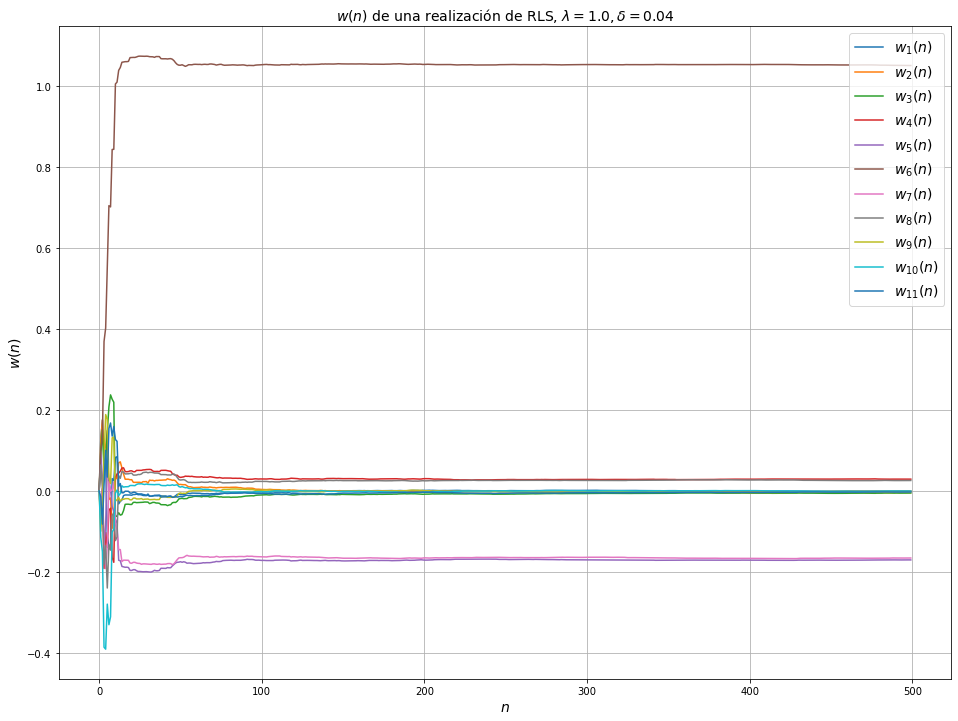

In [15]:
plt.figure(figsize=(16, 12))
for i in range(M):
    plt.plot(w_rls[:, i], label='$w_{%s}(n)$' % (i + 1))
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$w(n)$', fontsize=14)
plt.grid(True)
plt.title('$w(n)$ de una realización de RLS, $\lambda=%s, \delta=%s$' % (lamda, delta), fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

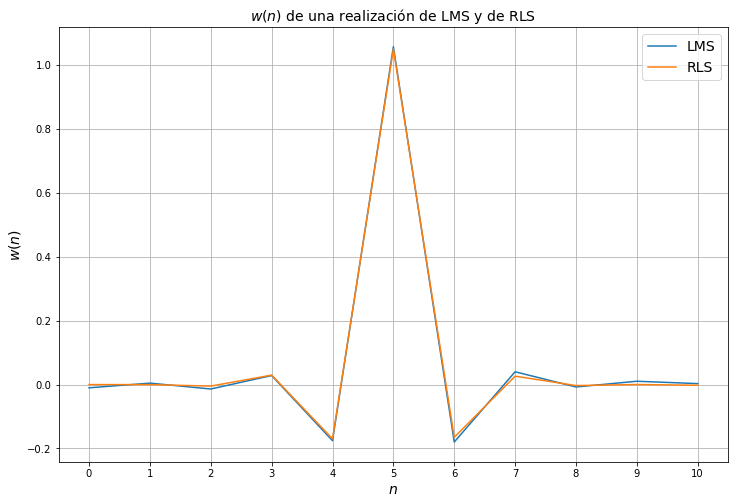

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(w_lms[499, :], label='LMS')
plt.plot(w_rls[499, :], label='RLS')
plt.xlabel('$n$', fontsize=14)
plt.xticks(np.arange(0, 11, 1))
plt.ylabel('$w(n)$', fontsize=14)
plt.grid(True)
plt.title('$w(n)$ de una realización de LMS y de RLS', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

* LMS y RLS convergen al mismo filtro.

## Convergencia de 10000 realizaciones

En el primer experimento comparamos LMS y RLS con un nivel de ruido bajo: $\sigma^2_v = 0.001$.

In [17]:
sigma2v = 0.001
K = 10000

In [18]:
w1_lms_mc, J1_lms_mc = calc_lms_montecarlo(K, mu, N, w0, W[0])
w2_lms_mc, J2_lms_mc = calc_lms_montecarlo(K, mu, N, w0, W[1])
w3_lms_mc, J3_lms_mc = calc_lms_montecarlo(K, mu, N, w0, W[2])
w4_lms_mc, J4_lms_mc = calc_lms_montecarlo(K, mu, N, w0, W[3])

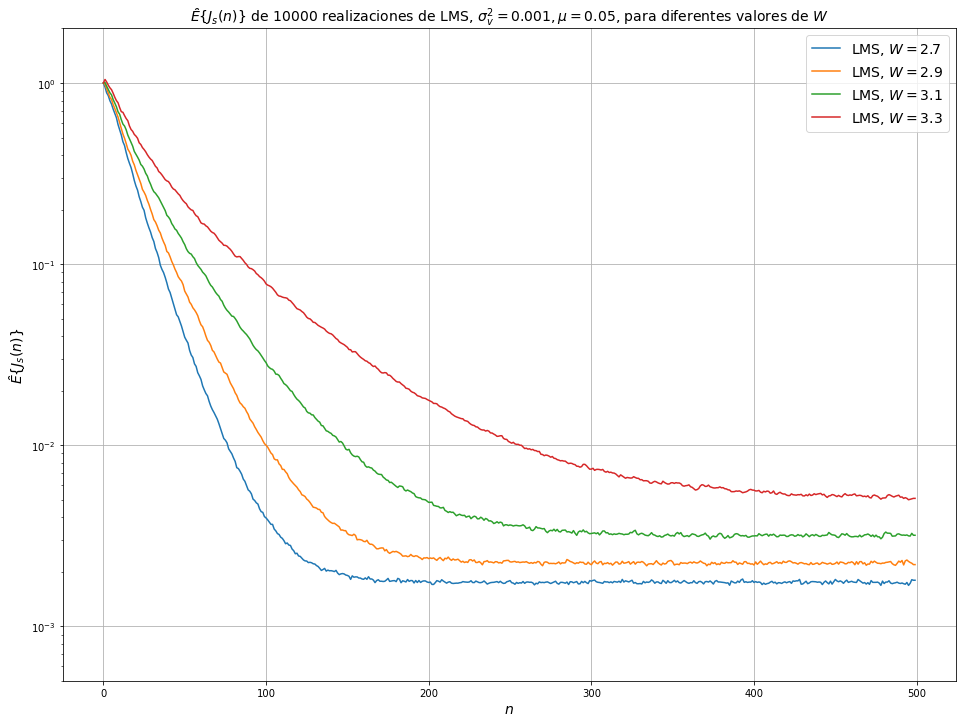

In [19]:
plt.figure(figsize=(16, 12))
plt.semilogy(J1_lms_mc, label='LMS, $W=%s$' % W[0])
plt.semilogy(J2_lms_mc, label='LMS, $W=%s$' % W[1])
plt.semilogy(J3_lms_mc, label='LMS, $W=%s$' % W[2])
plt.semilogy(J4_lms_mc, label='LMS, $W=%s$' % W[3])
plt.ylim(0.0005, 2)
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$Ȇ\{J_s(n)\}$', fontsize=14)
plt.grid(True)
plt.title('$Ȇ\{J_s(n)\}$ de %s realizaciones de LMS, $\sigma^2_v=%s, µ=%s$, para diferentes valores de $W$' % (K, sigma2v, mu), fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [20]:
w1_rls_mc, J1_rls_mc = calc_rls_montecarlo(K, lamda, delta, N, w0, W[0])
w2_rls_mc, J2_rls_mc = calc_rls_montecarlo(K, lamda, delta, N, w0, W[1])
w3_rls_mc, J3_rls_mc = calc_rls_montecarlo(K, lamda, delta, N, w0, W[2])
w4_rls_mc, J4_rls_mc = calc_rls_montecarlo(K, lamda, delta, N, w0, W[3])

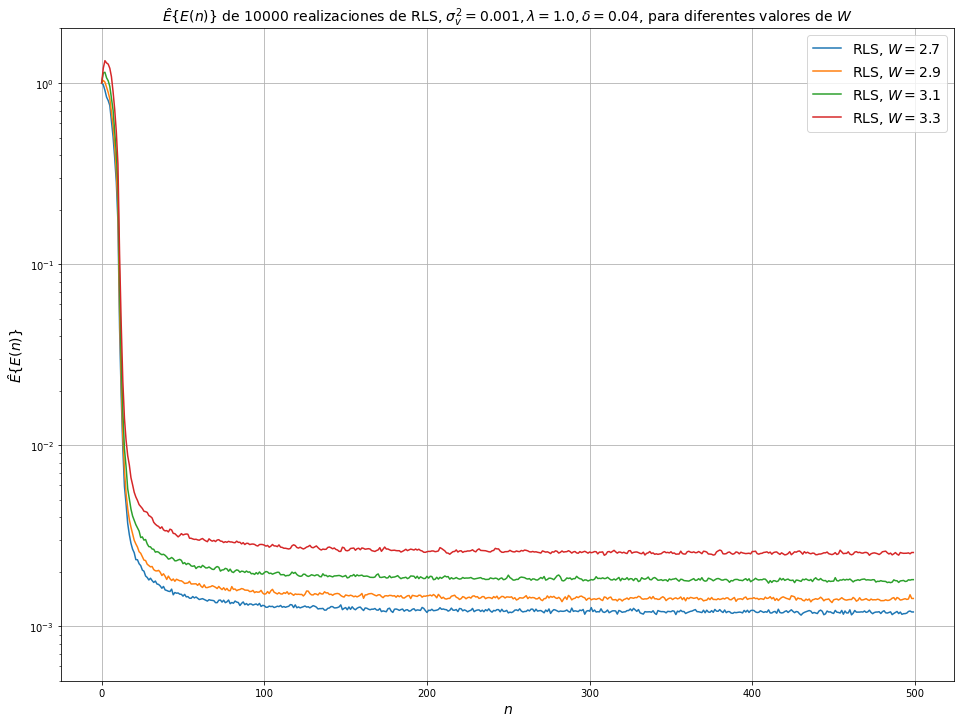

In [21]:
plt.figure(figsize=(16, 12))
plt.semilogy(J1_rls_mc, label='RLS, $W=%s$' % W[0])
plt.semilogy(J2_rls_mc, label='RLS, $W=%s$' % W[1])
plt.semilogy(J3_rls_mc, label='RLS, $W=%s$' % W[2])
plt.semilogy(J4_rls_mc, label='RLS, $W=%s$' % W[3])
plt.ylim(0.0005, 2)
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$Ȇ\{E(n)\}$', fontsize=14)
plt.grid(True)
plt.title('$Ȇ\{E(n)\}$ de %s realizaciones de RLS, $\sigma^2_v=%s, \lambda=%s, \delta=%s$, para diferentes valores de $W$' % (K, sigma2v, lamda, delta), fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

* RLS converge en aproximadamente 20 pasos.
* La tasa de convergencia es relativamente independiente del spread de autovalores $χ(R)$.
* RLS converge mucho más rápidamente que LMS.
* El error estacionario de RLS es menor que el de LMS.

En el segundo experimento comparamos LMS y RLS con un nivel de ruido alto: $\sigma^2_v = 0.1$.

In [22]:
sigma2v = 0.1

In [23]:
w5_lms_mc, J5_lms_mc = calc_lms_montecarlo(K, mu, N, w0, W[0])
w6_lms_mc, J6_lms_mc = calc_lms_montecarlo(K, mu, N, w0, W[1])
w7_lms_mc, J7_lms_mc = calc_lms_montecarlo(K, mu, N, w0, W[2])
w8_lms_mc, J8_lms_mc = calc_lms_montecarlo(K, mu, N, w0, W[3])

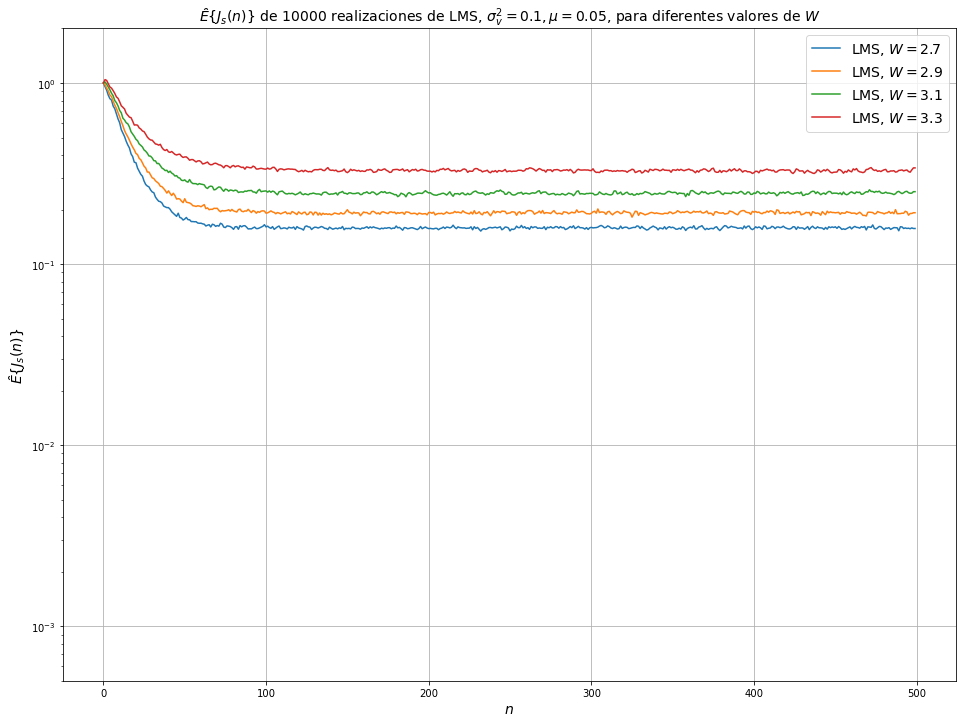

In [24]:
plt.figure(figsize=(16, 12))
plt.semilogy(J5_lms_mc, label='LMS, $W=%s$' % W[0])
plt.semilogy(J6_lms_mc, label='LMS, $W=%s$' % W[1])
plt.semilogy(J7_lms_mc, label='LMS, $W=%s$' % W[2])
plt.semilogy(J8_lms_mc, label='LMS, $W=%s$' % W[3])
plt.ylim(0.0005, 2)
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$Ȇ\{J_s(n)\}$', fontsize=14)
plt.grid(True)
plt.title('$Ȇ\{J_s(n)\}$ de %s realizaciones de LMS, $\sigma^2_v=%s, µ=%s$, para diferentes valores de $W$' % (K, sigma2v, mu), fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [25]:
w5_rls_mc, J5_rls_mc = calc_rls_montecarlo(K, lamda, delta, N, w0, W[0])
w6_rls_mc, J6_rls_mc = calc_rls_montecarlo(K, lamda, delta, N, w0, W[1])
w7_rls_mc, J7_rls_mc = calc_rls_montecarlo(K, lamda, delta, N, w0, W[2])
w8_rls_mc, J8_rls_mc = calc_rls_montecarlo(K, lamda, delta, N, w0, W[3])

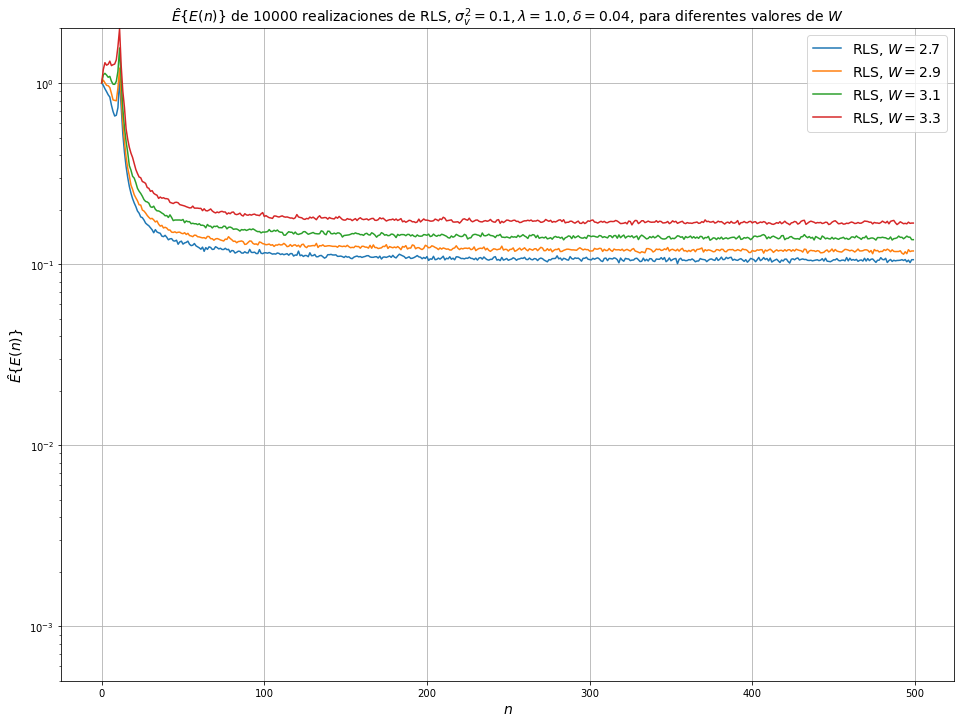

In [26]:
plt.figure(figsize=(16, 12))
plt.semilogy(J5_rls_mc, label='RLS, $W=%s$' % W[0])
plt.semilogy(J6_rls_mc, label='RLS, $W=%s$' % W[1])
plt.semilogy(J7_rls_mc, label='RLS, $W=%s$' % W[2])
plt.semilogy(J8_rls_mc, label='RLS, $W=%s$' % W[3])
plt.ylim(0.0005, 2)
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$Ȇ\{E(n)\}$', fontsize=14)
plt.grid(True)
plt.title('$Ȇ\{E(n)\}$ de %s realizaciones de RLS, $\sigma^2_v=%s, \lambda=%s, \delta=%s$, para diferentes valores de $W$' % (K, sigma2v, lamda, delta), fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.show()

* La tasa de convergencia de LMS y RLS es similar.
* Ambos requieren aproximadamente 40 pasos para converger.